In [1]:
from rsna_retro.imports import *
from rsna_retro.metadata import *
from rsna_retro.preprocess import *
from rsna_retro.train import *
from rsna_retro.train3d import *

In [2]:
torch.cuda.set_device(3)

In [3]:
df_any = meta.df_any
df_any.head()

,Modality,PatientID,StudyInstanceUID,SeriesInstanceUID,StudyID,ImagePositionPatient,ImageOrientationPatient,SamplesPerPixel,PhotometricInterpretation,Rows,...,MultiWindowCenter,WindowCenter1,MultiWindowWidth,WindowWidth1,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
SOPInstanceUID,,,,,,,,,,,,,,,,,,,,,
ID_2a8702d25,CT,ID_ff137633,ID_d17053848c,ID_7098f7c836,,-126.437378,1.0,1,MONOCHROME2,512,...,NaN,NaN,NaN,NaN,1,0,1,1,0,0
ID_66891ac22,CT,ID_42940b2c,ID_17e33f43d0,ID_e14dd0090b,,-125.000000,1.0,1,MONOCHROME2,512,...,NaN,NaN,NaN,NaN,1,0,1,0,0,0
ID_8e6e5b51f,CT,ID_76fbed32,ID_1d8eaa14ef,ID_e3919709a0,,-125.000000,1.0,1,MONOCHROME2,512,...,NaN,NaN,NaN,NaN,1,0,0,0,0,1
ID_cb8b9b514,CT,ID_20039b63,ID_1cfe3e70dd,ID_e3b5d8d9b8,,-125.000000,1.0,1,MONOCHROME2,512,...,NaN,NaN,NaN,NaN,0,0,0,0,0,0
ID_ee683911f,CT,ID_a065f3ac,ID_9c727ac231,ID_99e83a310d,,-125.000000,1.0,1,MONOCHROME2,512,...,1.0,40.0,1.0,80.0,0,0,0,0,0,0


In [4]:
# dbunch = get_3d_dbunch(df_any)

In [5]:
dsrc_feat = get_3d_dsrc(df_any, open_fn=OpenFeats(path/'features_256'))

In [6]:
dbunch_feat = DataBunch(
    TfmdDL(dsrc_feat.train, bs=None, after_batch=[Cuda()], num_workers=8, shuffle=True),
    TfmdDL(dsrc_feat.valid, bs=None, after_batch=[Cuda()], num_workers=8)
)
dbunch_feat.device = default_device()
dbunch_feat.c = 6

In [7]:
x,y = dbunch_feat.one_batch()
x.shape, y.shape

(torch.Size([35, 512, 8, 8]), torch.Size([35, 6]))

## Model

In [8]:
m = get_3d_head()

In [9]:
# def get_model_learner(dbch, model, lf=None, pretrained=False, opt_func=None, metrics=None, fp16=True, config=None):
#     if lf is None: lf = get_loss()
#     if metrics is None: metrics=[accuracy_multi,accuracy_any]
#     if opt_func is None: opt_func = partial(Adam, wd=1e-5, eps=1e-4, sqr_mom=0.999)
#     if config is None: config=dict(ps=0., lin_ftrs=[], concat_pool=False)
#     learn = Learner(dbch, model, loss_func=lf, lr=3e-3,
#                         opt_func=opt_func, metrics=metrics)
#     return learn.to_fp16() if fp16 else learn

In [10]:
learn = get_learner(dbunch_feat, m)

In [11]:
# learn.load(f'runs/baseline_any-2b', strict=False)

In [12]:
# learn.summary()

## Training

In [13]:
name = 'train3d_baseline_feat'

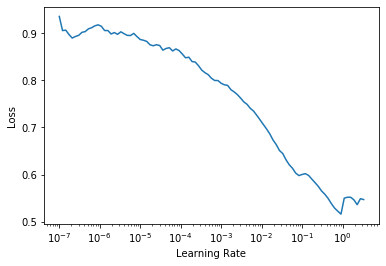

In [14]:
learn.lr_find()

In [16]:
do_fit(learn, 10, 1e-1, freeze=False)
learn.save(f'runs/{name}-1')

epoch,train_loss,valid_loss,accuracy_multi,accuracy_any,time
0,0.135155,0.214164,0.931065,0.885631,03:52
1,0.213401,0.229078,0.923012,0.887829,03:46
2,0.170092,0.232511,0.919551,0.888730,03:50
3,0.176979,0.230316,0.919860,0.854748,03:52
4,0.161665,0.204675,0.925754,0.896411,03:51
5,0.167329,0.202366,0.928116,0.894266,03:47
6,0.138112,0.216220,0.926840,0.894716,03:39
7,0.130728,0.209328,0.934004,0.896411,03:43
8,0.124092,0.196365,0.937853,0.897629,03:46
9,0.106443,0.186476,0.943301,0.901973,03:47
